# Using Deep Learning in Time Series Analysis

In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

C:\Users\alkaa\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

In [4]:
print(tf.__version__)

2.15.0


In [5]:
tf.random.set_seed(51)
np.random.seed(51)

## Appliance Energy Dataset

In [6]:
df = pd.read_csv('energydata_complete.csv')
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [7]:
df = df[::6]
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.79,19.79,44.730000,19.000000,...,17.033333,45.530000,6.6,733.5,92.0,7.0,63.0,5.3,13.275433,13.275433
6,2016-01-11 18:00:00,60,50,19.890000,45.766667,19.200000,44.50,19.79,44.900000,18.890000,...,17.000000,45.290000,5.9,734.1,92.0,5.0,40.0,4.7,47.233763,47.233763
12,2016-01-11 19:00:00,430,50,20.133333,48.000000,19.566667,44.40,19.89,44.900000,19.000000,...,16.963333,45.290000,6.0,734.5,91.0,6.0,40.0,4.6,34.351142,34.351142
18,2016-01-11 20:00:00,80,30,20.890000,51.193333,20.200000,46.33,20.20,48.193333,18.963333,...,16.890000,45.200000,6.0,735.2,88.0,6.0,40.0,4.1,19.001759,19.001759
24,2016-01-11 21:00:00,110,30,21.133333,46.060000,20.426667,44.76,20.29,46.433333,19.390000,...,16.890000,44.966667,6.0,735.4,87.0,6.0,40.0,3.9,13.361033,13.361033


In [8]:
df.shape

(3290, 29)

In [9]:
date_time = pd.to_datetime(df.pop('date'), format='%Y.%m.%d %H:%M:%S')

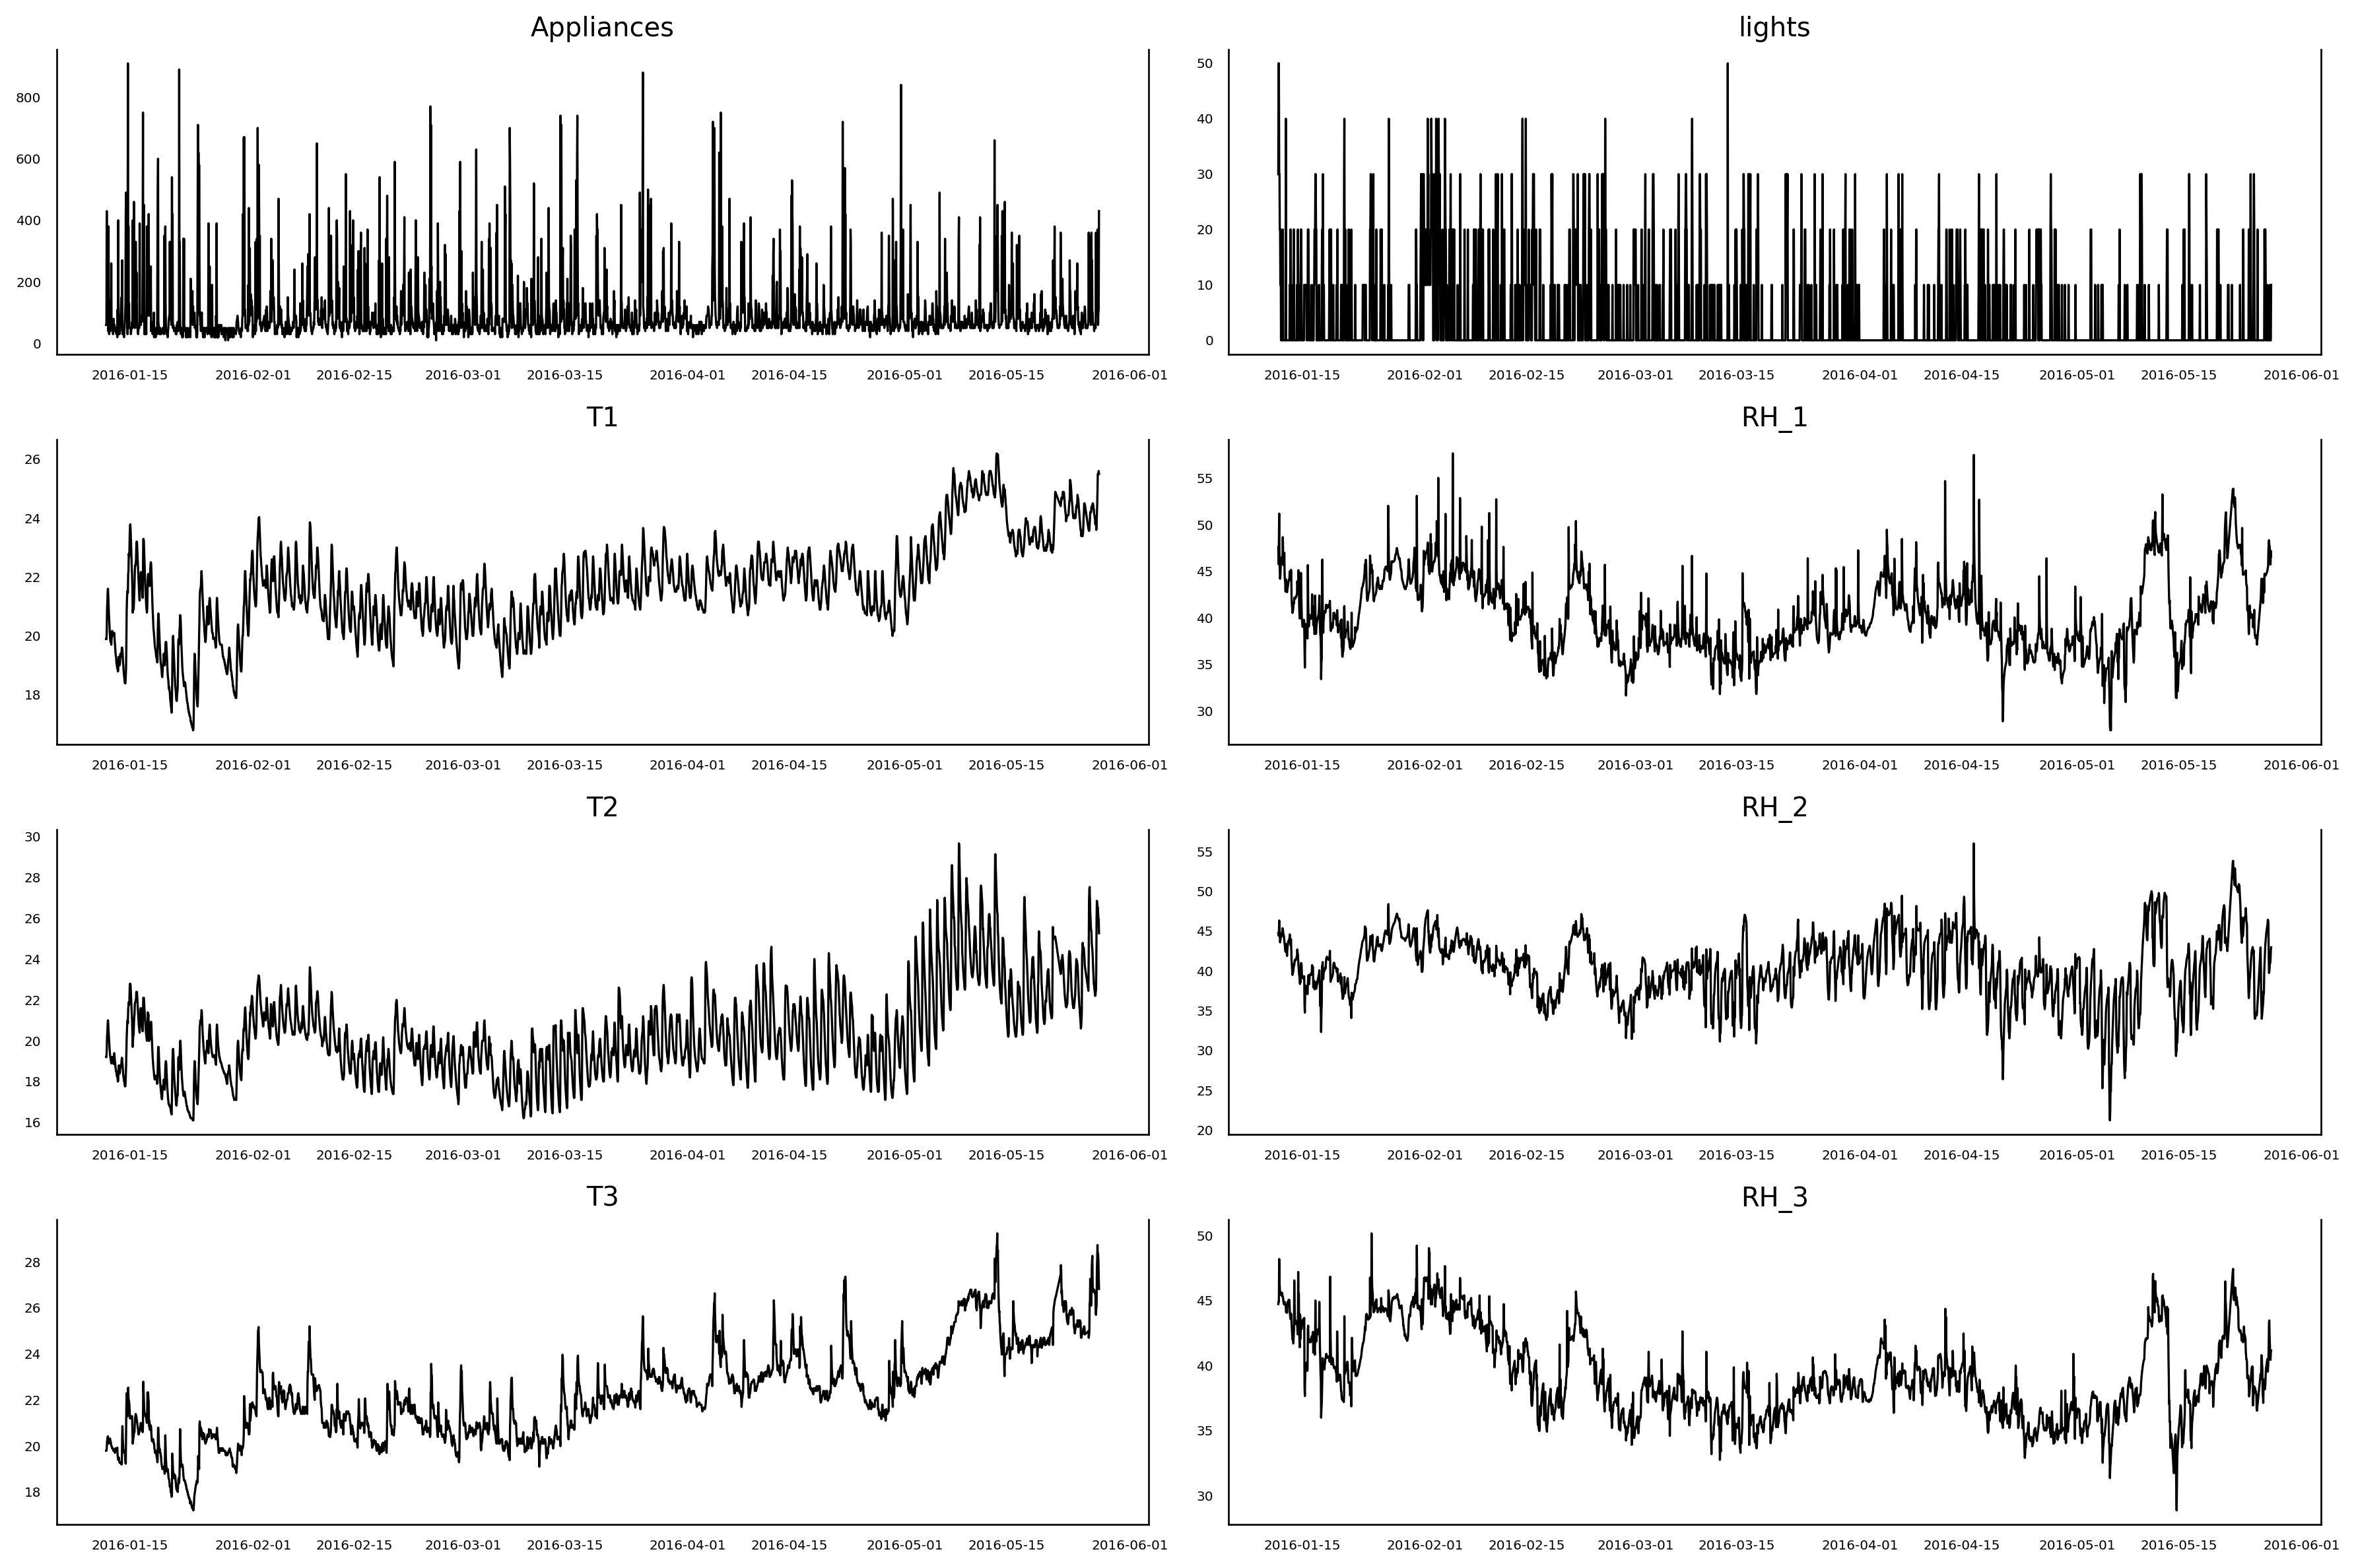

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=240, figsize=(15, 10))

for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    data.index = date_time
    ax.plot(data, color='black', linewidth=1)
    
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

## Exploratory Data Analysis 

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Appliances,3290.0,96.835866,100.459209,10.000000,50.000000,60.000000,100.000000,910.000000
lights,3290.0,3.802432,7.954943,0.000000,0.000000,0.000000,0.000000,50.000000
T1,3290.0,21.686138,1.606259,16.790000,20.737500,21.600000,22.600000,26.200000
RH_1,3290.0,40.262549,3.992042,27.926667,37.372500,39.650833,43.090000,57.663333
T2,3290.0,20.342054,2.195577,16.100000,18.790000,20.000000,21.500000,29.663333
RH_2,3290.0,40.423351,4.072868,21.230000,37.888750,40.500000,43.260000,56.026667
T3,3290.0,22.266861,2.006131,17.200000,20.790000,22.100000,23.290000,29.236000
RH_3,3290.0,39.241405,3.254206,28.860000,36.900000,38.537500,41.752500,50.163333
T4,3290.0,20.856308,2.043188,15.100000,19.500000,20.633333,22.100000,26.140000
RH_4,3290.0,39.026112,4.343764,28.424286,35.527500,38.400000,42.152500,50.963333


In [12]:
drop_cols = ['lights', 'rv1', 'rv2']
df = df.drop(drop_cols, axis=1)

In [13]:
df.shape

(3290, 25)

In [14]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Appliances,3290.0,96.835866,100.459209,10.000000,50.000000,60.000000,100.000000,910.000000
T1,3290.0,21.686138,1.606259,16.790000,20.737500,21.600000,22.600000,26.200000
RH_1,3290.0,40.262549,3.992042,27.926667,37.372500,39.650833,43.090000,57.663333
T2,3290.0,20.342054,2.195577,16.100000,18.790000,20.000000,21.500000,29.663333
RH_2,3290.0,40.423351,4.072868,21.230000,37.888750,40.500000,43.260000,56.026667
T3,3290.0,22.266861,2.006131,17.200000,20.790000,22.100000,23.290000,29.236000
RH_3,3290.0,39.241405,3.254206,28.860000,36.900000,38.537500,41.752500,50.163333
T4,3290.0,20.856308,2.043188,15.100000,19.500000,20.633333,22.100000,26.140000
RH_4,3290.0,39.026112,4.343764,28.424286,35.527500,38.400000,42.152500,50.963333
T5,3290.0,19.593729,1.846567,15.335000,18.290000,19.390000,20.613492,25.466667


## Feature Engineering

In [15]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

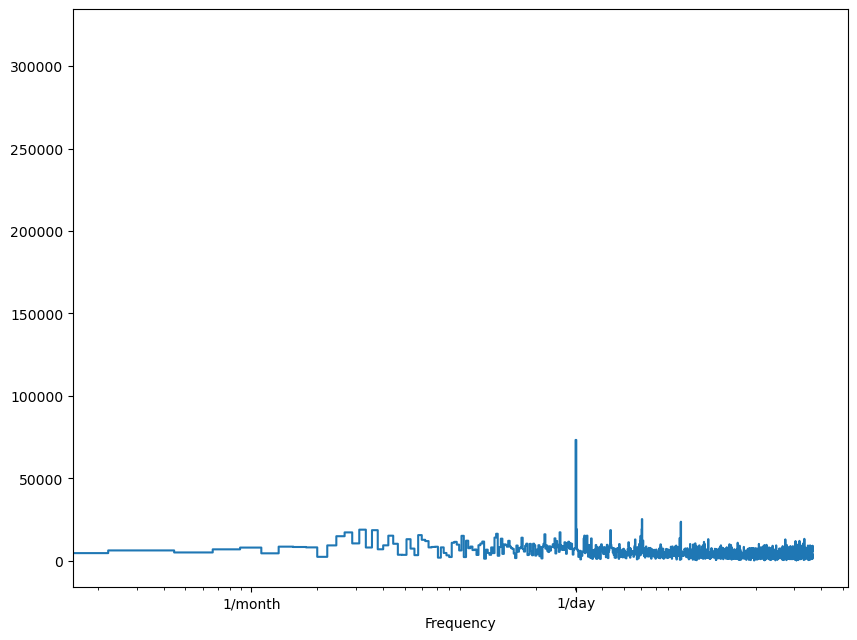

In [16]:
fft = tf.signal.rfft(df['Appliances'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['Appliances'])
hours_per_month = 24 * 30.4167
months_per_dataset = n_sample_h/hours_per_month

f_per_month = f_per_dataset / months_per_dataset

plt.step(f_per_month, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 30.4167], labels=['1/month', '1/day'])
plt.xlabel('Frequency')
plt.show()

In [17]:
day = 24 * 60 * 60

df['Day sin'] = (np.sin(timestamp_s * (2 * np.pi / day))).values
df['Day cos'] = (np.cos(timestamp_s * (2 * np.pi / day))).values

In [18]:
df.head()

,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Day sin,Day cos
0,60,19.890000,47.596667,19.200000,44.79,19.79,44.730000,19.000000,45.566667,17.166667,...,17.033333,45.530000,6.6,733.5,92.0,7.0,63.0,5.3,0.130526,-0.991445
6,60,19.890000,45.766667,19.200000,44.50,19.79,44.900000,18.890000,45.790000,17.100000,...,17.000000,45.290000,5.9,734.1,92.0,5.0,40.0,4.7,-0.130526,-0.991445
12,430,20.133333,48.000000,19.566667,44.40,19.89,44.900000,19.000000,46.363333,17.100000,...,16.963333,45.290000,6.0,734.5,91.0,6.0,40.0,4.6,-0.382683,-0.923880
18,80,20.890000,51.193333,20.200000,46.33,20.20,48.193333,18.963333,48.630000,17.200000,...,16.890000,45.200000,6.0,735.2,88.0,6.0,40.0,4.1,-0.608761,-0.793353
24,110,21.133333,46.060000,20.426667,44.76,20.29,46.433333,19.390000,48.193333,17.760000,...,16.890000,44.966667,6.0,735.4,87.0,6.0,40.0,3.9,-0.793353,-0.608761


## Splitting the data

In [19]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

print(f'There are {num_features} features')

There are 27 features


## Normalize the data

In [20]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

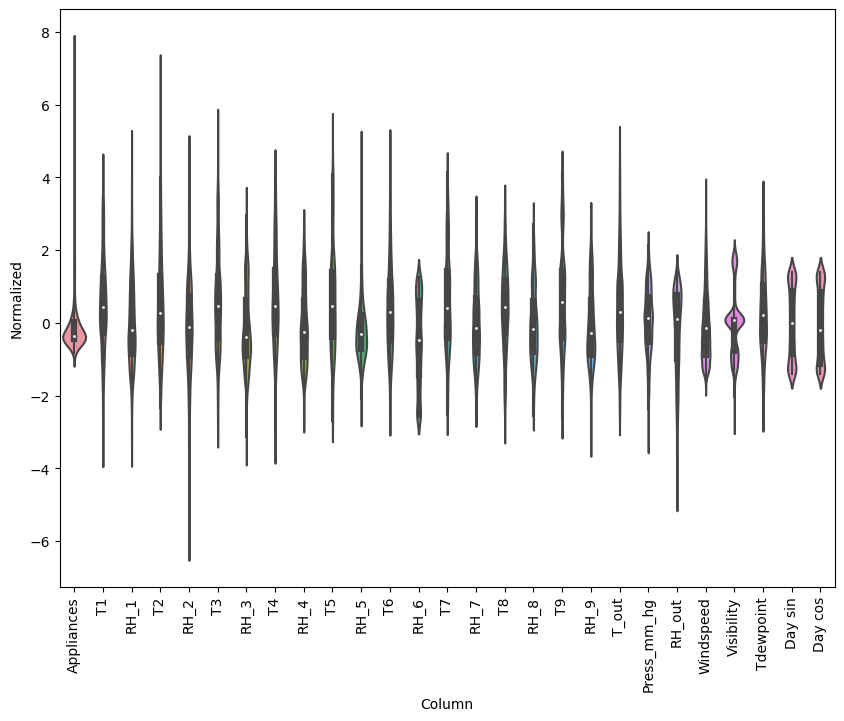

In [21]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data Windowing

In [30]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Appliances', max_subplots=3):
        inputs, labels = self.example
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)
            if n == 0:
                plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_window)
        return ds
    
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)  
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    @property
    def test(self):
        return self.make_dataset(self.test_df)    
    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

    

In [31]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=3):
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   patience=patience, 
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(), 
                  optimizer=Adam(), 
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=MAX_EPOCHS,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [32]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=['Appliances'])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Appliances']

In [33]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [34]:
baseline = Baseline(label_index=column_indices['Appliances'])

baseline.compile(loss=MeanSquaredError(),
                metrics=[MeanAbsoluteError()])

In [35]:
val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


21/21 [==============================] - 1s 5ms/step - loss: 0.7669 - mean_absolute_error: 0.3881


In [36]:
wide_window = WindowGenerator(input_width=24,
                             label_width=24,
                             shift=1,
                             label_columns=['Appliances'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Appliances']

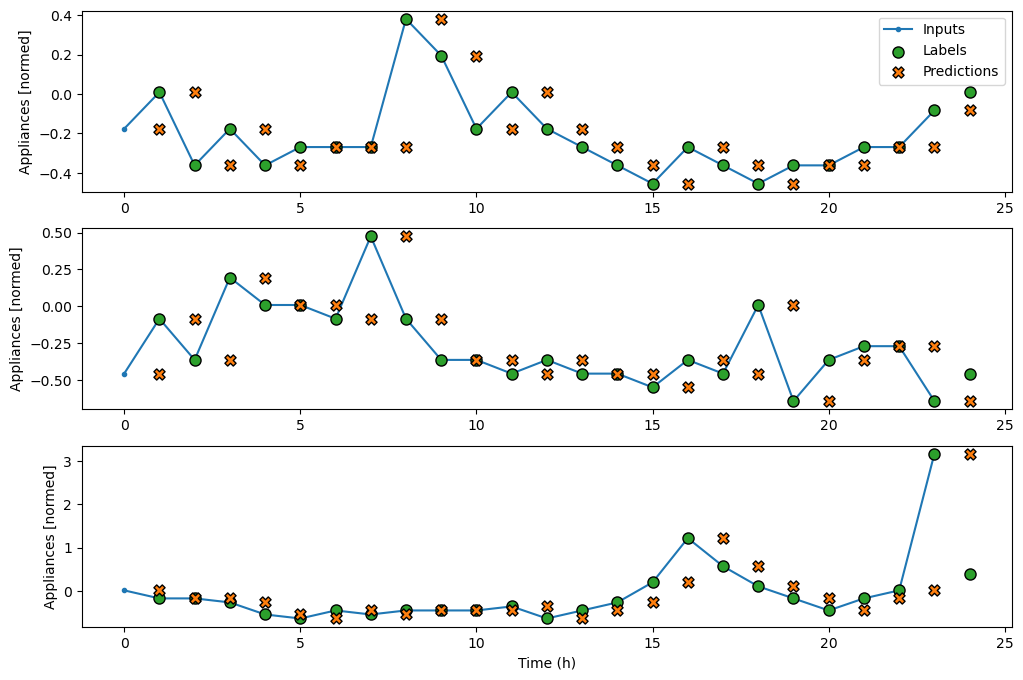

In [37]:
wide_window.plot(baseline)

### Linear Model

In [38]:
linear = Sequential([
    Dense(units=1)
])

In [39]:
history = compile_and_fit(linear, single_step_window)

val_performance['linear'] = linear.evaluate(single_step_window.val)
performance['linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 2s 6ms/step - loss: 2.5020 - mean_absolute_error: 1.2261 - val_loss: 1.9472 - val_mean_absolute_error: 1.1683
Epoch 2/50
72/72 [==============================] - 0s 3ms/step - loss: 1.5570 - mean_absolute_error: 0.9010 - val_loss: 1.1987 - val_mean_absolute_error: 0.8633
Epoch 3/50
72/72 [==============================] - 0s 3ms/step - loss: 1.2415 - mean_absolute_error: 0.7562 - val_loss: 0.9384 - val_mean_absolute_error: 0.7334
Epoch 4/50
72/72 [==============================] - 0s 3ms/step - loss: 1.1148 - mean_absolute_error: 0.6888 - val_loss: 0.8288 - val_mean_absolute_error: 0.6719
Epoch 5/50
72/72 [==============================] - 0s 3ms/step - loss: 1.0404 - mean_absolute_error: 0.6459 - val_loss: 0.7588 - val_mean_absolute_error: 0.6250
Epoch 6/50
72/72 [==============================] - 0s 3ms/step - loss: 0.9869 - mean_absolute_error: 0.6152 - val_loss: 0.7171 - val_mean_absolute_error: 0.5991
Epoch 7/50
72/72 [==========

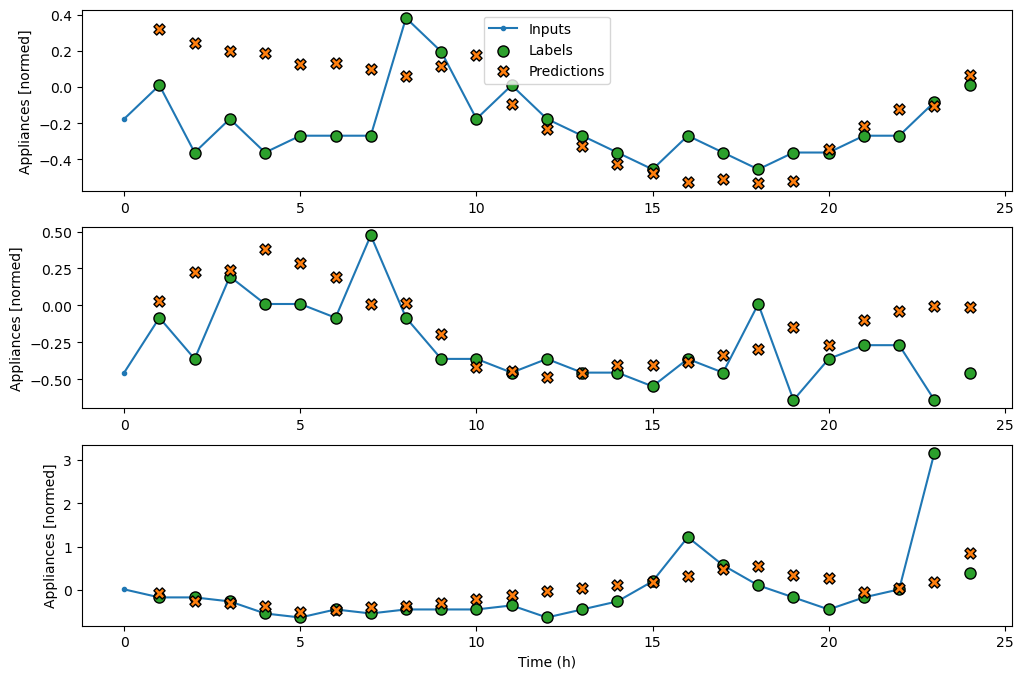

In [40]:
wide_window.plot(linear)